In [39]:
### Import the important libraries:
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import random
import cv2  #cv2. imread() method loads an image from the specified file.
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib # For data compression
import sklearn
import itertools  #functions creating iterators for efficient looping
import scipy
import skimage  # Library for image processing
from skimage.transform import resize
import csv
from tqdm import tqdm   #This make our loops show a smart progress meter - We just have to wrap any iterable with tqdm(iterable), and We're done!




from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight


import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers


from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc



import warnings
warnings.filterwarnings("ignore")

In [ ]:

import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers

from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16

import warnings
warnings.filterwarnings("ignore")

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16

In [11]:
## pip3 install --upgrade tensorflow ## To upgrade Tensorflow to the latest version
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
train_dir = "/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/train/"
test_dir =  "/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/test/"

print(train_dir)
print(test_dir)

/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/train/
/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/test/


# Dataset Folder Structure:
* Our data is located in three folders:
* train= contains the training data/images for teaching our model.
* val= contains images which we will use to validate our model. The purpose of this data set is to prevent our model from Overfitting. Overfitting is when your model gets a little too comofortable with the training data and can't handle data it hasn't see....too well.
* test = this contains the data that we use to test the model once it has learned the relationships between the images and their label (Pneumonia/Not-Pneumonia)

In [21]:
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)


# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

100%|██████████| 234/234 [01:34<00:00,  2.27it/s]


In [22]:
print("Shape of X train:",X_train.shape)
print("Shape of X test:",X_test.shape)
print("Shape of y train:",y_train.shape)
print("Shape of y test:",y_test.shape)

Shape of X train: (5216, 150, 150, 3)
Shape of X test: (624, 150, 150, 3)
Shape of y train: (5216,)
Shape of y test: (624,)


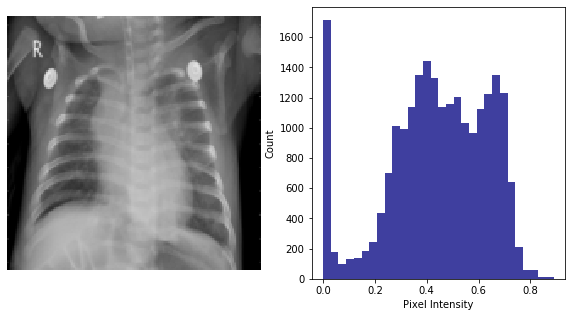

In [24]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

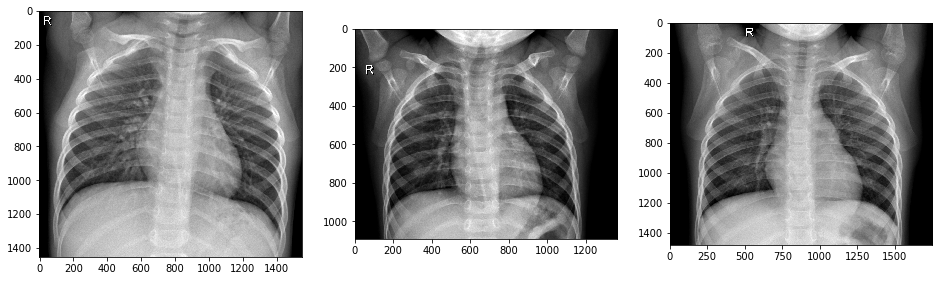

In [25]:
multipleImages = glob("/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/train/NORMAL/**")
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

No Pneumonia


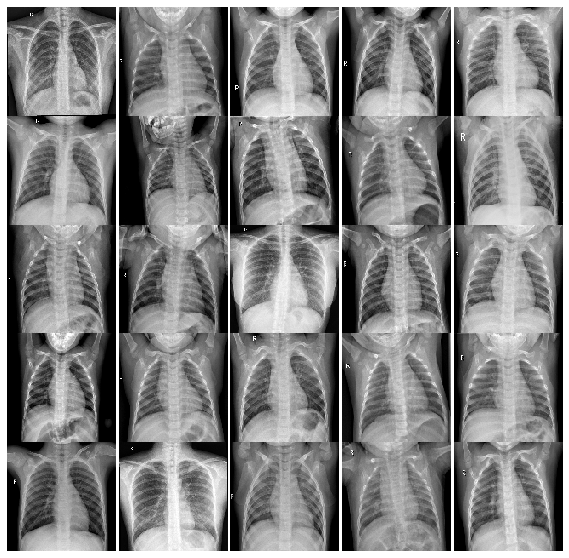

In [26]:
print("No Pneumonia")
multipleImages = glob("/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/train/NORMAL/**")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Yes Pneumonia


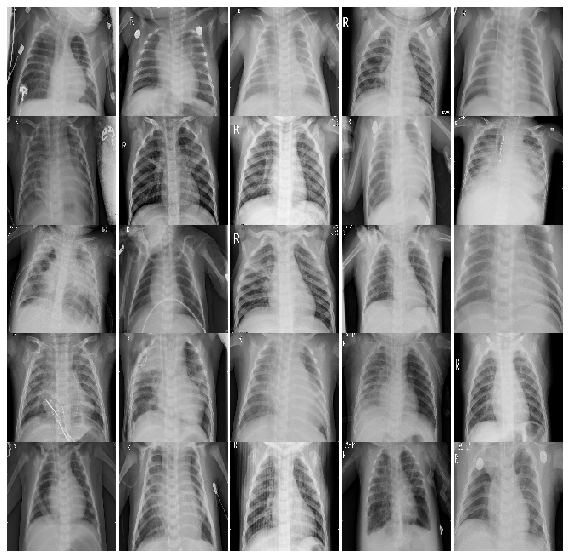

In [27]:
print("Yes Pneumonia")
multipleImages = glob("/Users/prasadbhoite/school/CAP_5610/Project/ChestX-ray_CAP5610/chest_xray/train/PNEUMONIA/**")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


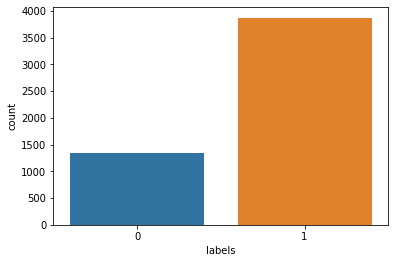

In [55]:
### Let's check whether the dataset is balanced or imbalanced?

map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [56]:
### Let's check whether the dataset is balanced or imbalanced?

map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
dist

## No Pneumonia= 1341 images 
## Pneumonia: 3875 images

1    3875
0    1341
Name: labels, dtype: int64

In [57]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [97]:
map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


optimizer1 = keras.optimizers.RMSprop(lr=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model


{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


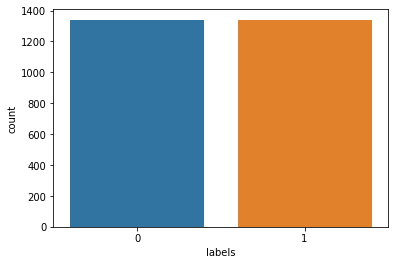

In [59]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
from imblearn.under_sampling import RandomUnderSampler


X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = 150,150,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = 150,150,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)


In [68]:
# Let's check the frequency of each class:
print(labRos.shape[0]/2)

1341.0


In [69]:
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.9448173  0.67303226]
New Class Weights:  [1. 1.]


In [74]:

### Let's create the pretrained models. Model 1-VGG16, Model 2- InceptionV3, Model 3- ResNet50.


pretrained_model_1 = VGG16(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))
pretrained_model_2 = InceptionV3(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))
pretrained_model_3 = ResNet50(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))

87916544/87910968 [==============================] - 9s 0us/step


In [98]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,2,3,optimizer1,map_characters1)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

NameError: name 'array' is not defined

In [93]:
## Let's run pretrainednetwork: Model 1--
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_1,weight_path1,class_weight2,2,3,optimizer1,map_characters1)

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [54]:
## Let's run pretrainednetwork: Model 1--
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, pretrained_model_1, weight_path1,class_weight1,2,3,optimizer1,map_characters1)



## Let's run pretrainednetwork: Model 2--
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, pretrained_model_2, weight_path1,class_weight1,2,3,optimizer1,map_characters1)



## Let's run pretrainednetwork: Model 3--
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_3,weight_path2,class_weight1,2,3,optimizer1,map_characters1)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
## Let's run pretrainednetwork: Model 2--

pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, pretrained_model_2, weight_path1,class_weight1,2,3,optimizer1,map_characters1)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [46]:
## Let's run pretrainednetwork: Model 3--
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_3,weight_path2,class_weight1,2,3,optimizer1,map_characters1)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [20]:
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,2,3,optimizer1,map_characters1)
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,2,3,optimizer1,map_characters1)

NameError: name 'y_trainHot' is not defined

In [ ]:
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_1,weight_path1,class_weight2,2,6,optimizer1,map_characters1)

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


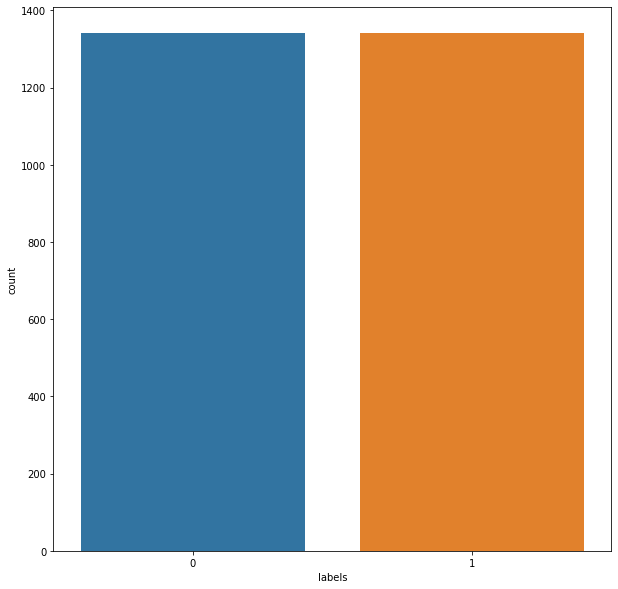

In [13]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
from imblearn.under_sampling import RandomUnderSampler


X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = 150,150,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = 150,150,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

Old Class Weights:  [1.9448173  0.67303226]
New Class Weights:  [1. 1.]


In [48]:
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_1,weight_path1,class_weight2,2,6,optimizer1,map_characters1)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [53]:
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_1,weight_path1,class_weight2,2,6,optimizer1,map_characters1)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()